In [2]:
%load_ext autoreload
%autoreload 1
%aimport my, qa

import sys
import numpy as np
import pandas as pd

import os
import gc
import matplotlib.pyplot as plt
import importlib
import pickle
import logging

import my, qa
from my import p
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option("max_colwidth", 45)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.5f}".format
# pd.set_option("display.max_rows", 5)
# pd.reset_option("display.max_rows")

from sklearn.model_selection import train_test_split

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
     
out = "out/"
da = '/kaggle/input/kon2023/data/'

SEED = 34
np.random.seed(SEED)
N_CPU = os.cpu_count()
os.makedirs(out,exist_ok=True)

In [3]:
import torch
import transformers as trf
trf.__version__, torch.__version__

('4.27.4', '1.13.0')

Загрузка трейна и теста и переименование столбцов как принято в Question Answering: весь текст документа назовем context, label назовем question, extracted_part назовем answer

In [4]:
df = pd.read_json(da+'train.json')
df.columns = ['id', 'context', 'question', 'answer']
p(df.shape)
df[:3]

(1799, 4)


,id,context,question,answer
0,809436509,Извещение о проведении открытого конкурса...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения ...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника ...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить ...
2,4382157,Извещение о проведении электронного аукци...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения ...


In [5]:
df_test = pd.read_json(da+'test.json')
df_test.columns = ['id', 'context', 'question']
p(df_test.shape)
df_test[:3]

(318, 3)


,id,context,question
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказан...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукци...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 2226330053...,обеспечение исполнения контракта


Для исполнения контракта немного больше образцов:

In [6]:
df['question'].value_counts()

обеспечение исполнения контракта        988
обеспечение гарантийных обязательств    811
Name: question, dtype: int64

In [7]:
df_test['question'].value_counts()

обеспечение исполнения контракта        175
обеспечение гарантийных обязательств    143
Name: question, dtype: int64

Достанем из внутреннего словаря extracted_part значения для вычисления статистик

In [8]:
def get_targets(x):
    return pd.Series({k:v[0] for k,v in x.items()})

df_target = df['answer'].apply(get_targets)
df = pd.concat([df,df_target],axis=1)
df[:3]

,id,context,question,answer,text,answer_start,answer_end
0,809436509,Извещение о проведении открытого конкурса...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения ...,Размер обеспечения исполнения контракта 6...,1279,1343
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника ...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить ...,Поставщик должен предоставить обеспечение...,1222,1318
2,4382157,Извещение о проведении электронного аукци...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения ...,Размер обеспечения исполнения контракта 1...,1297,1343


Проверим, что длина text совпадает с фрагментом context, полученным между answer_start и answer_end:

In [9]:
df[['context', 'text', 'answer_start', 'answer_end']].apply(lambda x:x['context'][x['answer_start']:x['answer_end']]==x['text'],axis=1).mean()

1.0

Количество контекстов в трейне, в которых нет ответа, примерно в 5 раз меньше, чем тех, где он есть:

In [10]:
(df['text']!='').value_counts()

True     1492
False     307
Name: text, dtype: int64

Из графиков видно, что большинство ответов лежит после 900-ого символа и до 1600 символа в контексте - это можно использовать, чтобы отбрасывать ответы не попадающие в этот интервал.

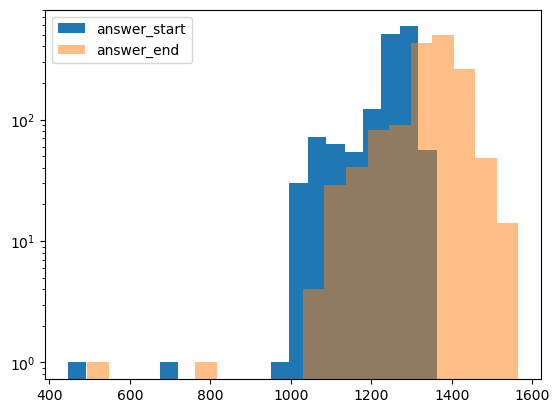

In [11]:
pos = df.loc[df['text']!='',['answer_start','answer_end']]

fig,ax = plt.subplots()
ax.hist(pos['answer_start'],bins=20,label='answer_start',log=True)
ax.hist(pos['answer_end'],bins=20,label='answer_end',alpha = 0.5)
_ = ax.legend()

Для той же цели - определения примерных диапазонов, в которых могут находиться ответы, посмотрим на распределение длин вопросов и контекстов в словах:

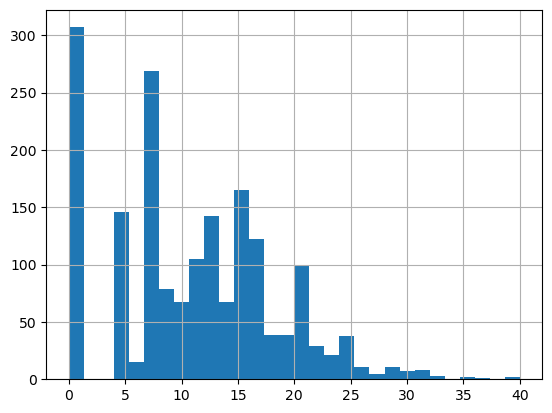

In [12]:
len_in_words = lambda x:len(x.split())
df['len_ans'] = df['text'].apply(len_in_words)
df['len_ctx'] = df['context'].apply(len_in_words)

df['len_ans'].hist(bins=30);

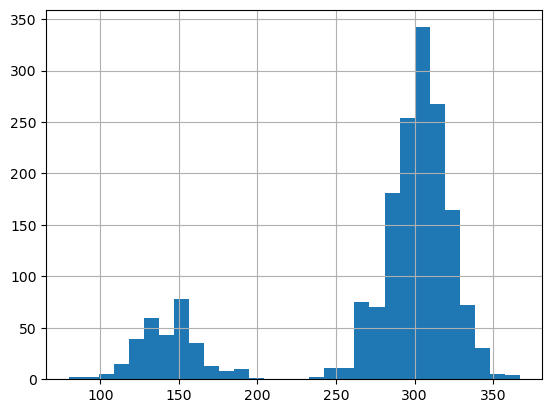

In [13]:
df['len_ctx'].hist(bins=30);

In [14]:
from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    PreTrainedTokenizerFast,
    TrainingArguments,
    default_data_collator,
    Trainer,
    EarlyStoppingCallback
)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
tokenizer.is_fast, tokenizer.padding_side

(True, 'right')

Распределение длин вопросов и контекстов в токенах берта:

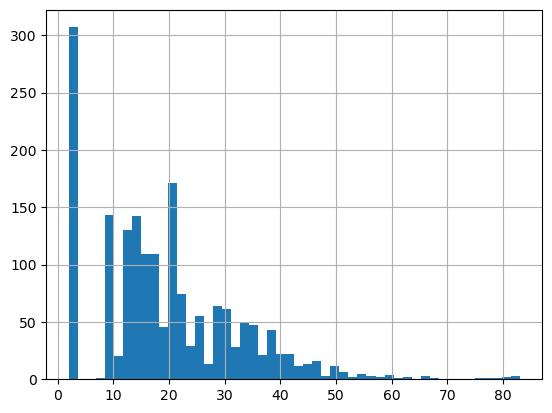

In [15]:
def len_in_tokens(se, tokenizer, plot=True):
    a_len = tokenizer(se.to_list(), padding=False, truncation=False)
    if plot:
        pd.Series([len(x) for x in a_len["input_ids"]]).hist(bins=50)

len_in_tokens(df['text'], tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors


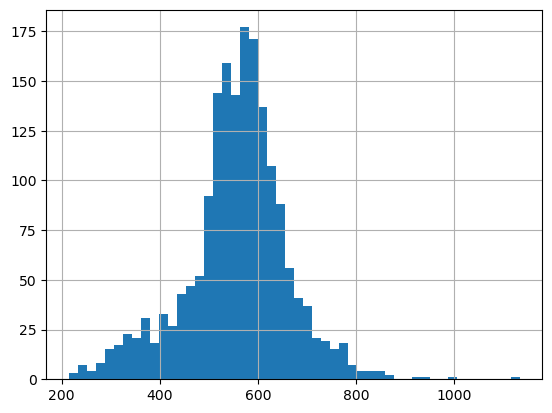

In [16]:
len_in_tokens(df['context'], tokenizer)

Видно, что длина контекста в токенах часто превосходит максимальную величину последовательности, принимаемую данной версией берта. Значит чтобы обработать полностью весь контекст, нам нужно будет разбивать его на части по 512 токенов, и потом объединять предсказания.

Распределим образцы по бинам по длине вопроса, по бинам по длине контекста, и по виду вопроса. 
Всю эту инфу аггрегируем в столбец stratify, с помощью него разобьем трейн стратифицировано по фолдам, 
в каждом фолде получим более однородный состав, как по длинам, так и по виду вопроса.

In [17]:
len_ans_bin = pd.cut(df['len_ans'],bins=[-1,0,12,np.inf], labels=False)
len_ctx_bin = pd.qcut(df['len_ctx'],q=10, labels=False)
question_bin = (df['question'] != 'обеспечение исполнения контракта').astype(int)

df['stratify'] = question_bin * 1000 + len_ans_bin*100 + len_ctx_bin

df = my.add_folds(df,strat_col='stratify',n_folds=5,seed=SEED)
df[:3]

StratifiedKFold


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


,id,context,question,answer,text,answer_start,answer_end,len_ans,len_ctx,stratify,fold
0,809436509,Извещение о проведении открытого конкурса...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения ...,Размер обеспечения исполнения контракта 6...,1279,1343,7,317,108,4
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника ...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить ...,Поставщик должен предоставить обеспечение...,1222,1318,13,296,204,0
2,4382157,Извещение о проведении электронного аукци...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения ...,Размер обеспечения исполнения контракта 1...,1297,1343,5,306,105,2


In [18]:
df['fold'].value_counts()

0    360
2    360
3    360
1    360
4    359
Name: fold, dtype: int64

### Тренировка на первом фолде

Для примера возьмем фолд номер 0 и получим hugging face датасеты для трейна, валидации, теста

In [19]:
from datasets import Dataset

FOLD = 0
COLS = ['context', 'question', 'answer']
train_ds = Dataset.from_pandas(df.loc[df.fold != FOLD,COLS],preserve_index=False)
val_ds = Dataset.from_pandas(df.loc[df.fold == FOLD,COLS+['id']],preserve_index=False)
test_ds = Dataset.from_pandas(df_test,preserve_index=False)
train_ds, val_ds, test_ds

(Dataset({
     features: ['context', 'question', 'answer'],
     num_rows: 1439
 }),
 Dataset({
     features: ['context', 'question', 'answer', 'id'],
     num_rows: 360
 }),
 Dataset({
     features: ['id', 'context', 'question'],
     num_rows: 318
 }))

Образцы в этих датасетах будут выглядеть так

In [20]:
def display_sample(x):
    x = x.copy()
    x['context'] = x['context'][:100] + " ... " + x['context'][-100:]
    return x
    
display_sample(train_ds[0])

{'context': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая ... луг и (или) поставленных товаров, подтверждающий цену оказанных услуг и (или) поставленных товаров 4',
 'question': 'обеспечение исполнения контракта',
 'answer': {'answer_end': [1343],
  'answer_start': [1279],
  'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль']}}

In [21]:
display_sample(test_ds[0])

{'id': 762883279,
 'context': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и ... нты-Мансийский автономный округ - Югра, г. Ханты-Мансийск, ул. Гагарина, 214 Почтовый адрес: 628011,',
 'question': 'обеспечение исполнения контракта'}

Для воспроизводимости

In [22]:
my.set_seed(SEED)
my.DEVICE

Random seed set as 34


device(type='cuda')

Определим некоторые параметры для тренировки модели. Будем разбивать контекст на отрывки длиной max_seq_length = 512 токенов, с пересечением этих отрывков doc_stride = 120 токенов с запасом (так как у нас ответы длиной максимум 80 токенов), на случай если ответ попадет на место разрыва контекста на отрывки.

In [23]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class CFG:
    model_name = 'cointegrated/LaBSE-en-ru'
#     model_name = 'sberbank-ai/sbert_large_mt_nlu_ru'
#     model_name = 'cointegrated/rubert-tiny2'
#     model_name = 'sberbank-ai/ruRoberta-large'
#     model_name = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'

    # train
    pad_to_max_length = False
    max_seq_length = 512
    doc_stride = 120

    # loops
    train_batch_size = 8
    val_batch_size = 16
    fp16=True

    # val and preds
    n_best_size = 15 # рассматриваем 15 вариантов от берта с наибольшей вероятностью
    version_2_with_negative = True # ответа может не быть в контексте
    min_answer_length = 5 # ответ не может быть длиной менее 5 токенов, за исключением пустого ответа
    max_answer_length = 100 # ответ не может быть длиной более 100 токенов
    null_score_diff_threshold = 0. # насколько больше/меньше должен быть минимальный пустой ответ,
                                   # чтобы его выбрать вместо непустого

    log_level = logging.INFO
    output_dir = 'out'

In [24]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name,
use_fast=True)
assert tokenizer.is_fast

tokenizer.is_fast, tokenizer.padding_side, tokenizer.model_max_length

(True, 'right', 512)

Токенизируем текстовые данные в формат, который принимает берт

In [25]:
tokenized_train_ds = train_ds.map(
                qa.prepare_train_features,
                fn_kwargs={
                    "tokenizer": tokenizer,
                    "cfg": CFG},
                batched=True,
                num_proc=2,
                remove_columns=train_ds.column_names,
                desc="Running tokenizer on train dataset",
            )
del train_ds

tokenized_val_ds = val_ds.map(
                qa.prepare_validation_features,
                fn_kwargs={
                    "tokenizer": tokenizer,
                    "cfg": CFG},
                batched=True,
                num_proc=2,
                remove_columns=val_ds.column_names,
                desc="Running tokenizer on validation dataset")

# добавляем нулевые признаки, так как Trainer из HF выполняет валидацию, только когда есть таргеты,
# для AutoModelForQuestionAnswering таргеты - это "start_positions" и "end_positions", по ним он
# вычисляет Validation Loss, но мы валидируемся по Accuracy
tokenized_val_ds = tokenized_val_ds.add_column(name="start_positions", column=[0]*len(tokenized_val_ds))
tokenized_val_ds = tokenized_val_ds.add_column(name="end_positions", column=[0]*len(tokenized_val_ds))

tokenized_test_ds = test_ds.map(
                qa.prepare_validation_features,
                fn_kwargs={
                    "tokenizer": tokenizer,
                    "cfg": CFG},
                batched=True,
                num_proc=2,
                remove_columns=test_ds.column_names,
                desc="Running tokenizer on test dataset")

tokenized_train_ds, tokenized_val_ds, tokenized_test_ds

Running tokenizer on train dataset #0:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on train dataset #1:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on validation dataset #0:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on validation dataset #1:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on test dataset #0:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on test dataset #1:   0%|          | 0/1 [00:00<?, ?ba/s]

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
     num_rows: 2526
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id', 'start_positions', 'end_positions'],
     num_rows: 637
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
     num_rows: 563
 }))

Напишем класс, который будет переводить предсказания берта на валидационных данных (логитсы) в отсортированный по убыванию вероятности набор текстовых ответов. По этому набору вычисляем Accuracy или точное совпадение с правильным ответом по первому предсказанному ответу (обозначена как exact1), по пяти первым ответам (exact5), по 10 первым ответам (exact10), также комбинированная метрика combined_exact_1_5, которая будет учитывать одновременно и exact1 и exact5

In [26]:
class MetricAfterPostpro():
    def __init__(self, tokenized_val_ds, val_ds, cfg) -> None:

        self.tokenized_val_ds = tokenized_val_ds
        self.val_ds = val_ds
        self.cfg = cfg
        
        self.results = {}
        
        for ex in self.val_ds:
            ctx_len = len(ex['context'])
            around_ans_start = max(0,ex['answer']['answer_start'][0] - 20)
            around_ans_end = min(ctx_len,ex['answer']['answer_start'][0] + len(ex['answer']['text'][0]) + 20)
            self.results[ex['id']] = {
                'around_ans': ex['context'][around_ans_start:around_ans_end],
                'TRUE_ANS': ex['answer']['text'][0]

            }

    def __call__(self, pred: EvalPrediction) -> dict:
        
        single_preds, top_variants, _ = qa.postprocess_preds(pred, self.tokenized_val_ds, self.val_ds, self.cfg)
        
        for ex_id, ans_text in single_preds.items():
            self.results[ex_id]['PRED_ANS'] = ans_text
            self.results[ex_id]['top'] = top_variants[ex_id][:10]
        
        exact1 = 0
        exact5 = 0
        exact10 = 0
        
        for (ex_id, v) in self.results.items():
            if v['PRED_ANS'] == v['TRUE_ANS']:
                exact1 += 1
            for i, el in enumerate(v['top']):
                if el['text'] == v['TRUE_ANS']:
                    if i < 5:
                        exact5 += 1
                    if i < 10:
                        exact10 += 1
                        
        n = len(self.results)             
        ms = {}            
        ms['exact1'] = exact1/n    
        ms['exact5'] = exact5/n
        ms['exact10'] = exact10/n
        ms['combined_exact_1_5'] = ms['exact1'] + (ms['exact5']/1000)
        ms['total_examples'] = n

        return ms

Тренируем модель AutoModelForQuestionAnswering используя EarlyStopping по метрике combined_exact_1_5. Validation loss принимает произвольные значения, так как для валидации указывали пустые значения start_positions и end_positions

In [27]:
import warnings
warnings.filterwarnings("ignore", ".*asked to gather along dimension.*")

model_name = CFG.model_name.split("/")[-1]

train_args = TrainingArguments(
    num_train_epochs=20,
    output_dir = f"{model_name}_qa_fold_{FOLD}",
    overwrite_output_dir = True,
    seed=SEED,
    optim='adamw_torch',
    evaluation_strategy="epoch",
    logging_strategy = 'steps',
    logging_steps = 20,
    save_strategy = "epoch",
    save_total_limit = 2,
    learning_rate=2e-5,
    per_device_train_batch_size=CFG.train_batch_size,
    per_device_eval_batch_size=CFG.val_batch_size,
    weight_decay=0.01,
    report_to="none",
    metric_for_best_model ='combined_exact_1_5',
    load_best_model_at_end = True,
    fp16 = CFG.fp16,
)

data_collator = (
        default_data_collator
        if CFG.pad_to_max_length
        else DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8 if CFG.fp16 else None)
    )

es = EarlyStoppingCallback(early_stopping_patience=5,early_stopping_threshold=0.000001)
postpro_metrics = MetricAfterPostpro(tokenized_val_ds, val_ds, CFG)

my.set_seed(SEED)

model = AutoModelForQuestionAnswering.from_pretrained(CFG.model_name)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=postpro_metrics,
    callbacks = [es]
)

train_result = trainer.train()
print('best_ckpts: ',trainer.state.best_model_checkpoint)
# https://discuss.huggingface.co/t/save-only-best-model-in-trainer/8442/15
# trainer.save_model(output_dir=new_path)

Random seed set as 34


Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the 

Epoch,Training Loss,Validation Loss,Exact1,Exact5,Exact10,Combined Exact 1 5,Total Examples
1,1.088500,4.540825,0.766667,0.905556,0.922222,0.767572,360
2,0.907000,4.330136,0.763889,0.908333,0.936111,0.764797,360
3,0.739900,4.666713,0.808333,0.905556,0.930556,0.809239,360
4,0.803900,5.487423,0.830556,0.919444,0.936111,0.831475,360
5,0.691100,6.616787,0.830556,0.930556,0.941667,0.831486,360
6,0.620600,6.146131,0.836111,0.927778,0.950000,0.837039,360
7,0.694200,6.321599,0.836111,0.922222,0.944444,0.837033,360
8,0.594300,5.163837,0.836111,0.927778,0.947222,0.837039,360
9,0.631600,6.724520,0.833333,0.933333,0.947222,0.834267,360
10,0.571200,5.836915,0.827778,0.922222,0.947222,0.828700,360


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

best_ckpts:  LaBSE-en-ru_qa_fold_0/checkpoint-948


In [28]:
q = trainer.evaluate(tokenized_val_ds)
q

  0%|          | 0/360 [00:00<?, ?it/s]

{'eval_loss': 6.1461310386657715,
 'eval_exact1': 0.8361111111111111,
 'eval_exact5': 0.9277777777777778,
 'eval_exact10': 0.95,
 'eval_combined_exact_1_5': 0.8370388888888889,
 'eval_total_examples': 360,
 'eval_runtime': 8.189,
 'eval_samples_per_second': 77.787,
 'eval_steps_per_second': 2.442,
 'epoch': 11.0}

Получили 59 неправильных ответов

In [29]:
q = postpro_metrics.results
wrong_ans = [v for ex_id, v in q.items() if v['PRED_ANS'] != v['TRUE_ANS']]
len(wrong_ans)

59

Предсказание модели (в данном случае неправильное) после пост процессинга выглядит так, можно посмотреть, какие вероятности модель присвоила разным ответам (around_ans - это окрестности правильного ответа):

In [30]:
wrong_ans[0]

{'around_ans': 'м учреждением] 8.1. Обеспечение исполнения настоящего Контракта установлено в размере 5,00% от цены контракта, а именно _______ рублей ____копеек. 8.2. Обеспечение ис',
 'TRUE_ANS': 'Обеспечение исполнения настоящего Контракта установлено в размере 5,00% от цены контракта, а именно _______ рублей ____копеек.',
 'PRED_ANS': 'Обеспечение исполнения настоящего Контракта установлено в размере 5,00% от цены контракта',
 'top': [{'start_logit': 11.8828125,
   'end_logit': 6.078125,
   'text': 'Обеспечение исполнения настоящего Контракта установлено в размере 5,00% от цены контракта',
   'start_end': (1310, 1399),
   'probability': 0.85888671875},
  {'start_logit': 11.8828125,
   'end_logit': 3.005859375,
   'text': 'Обеспечение исполнения настоящего Контракта установлено в размере 5,00% от цены контракта, а именно _______',
   'start_end': (1310, 1417),
   'probability': 0.03955078125},
  {'start_logit': 11.8828125,
   'end_logit': 2.69921875,
   'text': 'Обеспечение исполнен

Если посмотреть, что модель предсказала неправильно на валидации, а конкретно окончание TRUE ответов, то увидим, что в трейне есть явно некорректные ответы, например TRUE answer ответа 0 противоположен по логике TRUE answer ответа 2. Ответ 3 противоположен ответу 8. Также ответы из трейна могут обрываться на полу-слове, чего не может быть. Вероятно, ответы в трейне были сгенерированы какой-то другой моделью не с 100% точностью. И так как тестовые данные наверное из того же источника, что и трейн, то исправлять трейн в сторону правильной логики (что можно было сделать, добавив регулярные выражения) скорее всего не имеет смысла, потому что тест может не соответствовать правильной логике

In [31]:
for n in [0,2,3,8]:
    print(f'wrong answer № {n}')
    print('\tTRUE_ANS: ', wrong_ans[n]['TRUE_ANS'])
    print('\tPRED_ANS: ', wrong_ans[n]['PRED_ANS'])
    if n == 2:
        print('\n\n')

wrong answer № 0
	TRUE_ANS:  Обеспечение исполнения настоящего Контракта установлено в размере 5,00% от цены контракта, а именно _______ рублей ____копеек.
	PRED_ANS:  Обеспечение исполнения настоящего Контракта установлено в размере 5,00% от цены контракта
wrong answer № 2
	TRUE_ANS:  Обеспечение исполнения Контракта устанавливается в размере 0,5 % от цены Контракта, что составляет ___________ (____________
	PRED_ANS:  Обеспечение исполнения Контракта устанавливается в размере 0,5 % от цены Контракта, что составляет ___________ (____________) рублей ___ копеек



wrong answer № 3
	TRUE_ANS:  Заказчиком установлено требование обеспечения исполнения контракта в размере 10 процентов от цены контракта, что составляет: ______________________
	PRED_ANS:  Заказчиком установлено требование обеспечения исполнения контракта в размере 10 процентов от цены контракта
wrong answer № 8
	TRUE_ANS:  Размер обеспечения исполнения контракта: 30 % от начальной (максимальной) цены контракта
	PRED_ANS:  Ра

Предсказание модели на тесте, получаем logits для старта и конца ответов по каждому образцу:

In [32]:
test_outputs = trainer.predict(tokenized_test_ds)
test_outputs

PredictionOutput(predictions=(array([[ -3.982,  -8.71 ,  -9.945, ..., -10.85 , -10.484,  -3.984],
       [  2.07 ,  -8.234,  -8.92 , ..., -10.39 , -10.66 , -10.01 ],
       [ -6.887,  -9.18 , -10.26 , ..., -10.23 , -10.   ,  -6.887],
       ...,
       [ -2.104,  -6.723,  -7.652, ..., -10.48 ,  -9.52 ,  -2.104],
       [  4.863,  -4.047,  -5.2  , ..., -10.46 , -10.27 ,  -9.4  ],
       [  4.953,  -4.973,  -5.293, ..., -10.234, -10.04 ,  -9.36 ]],
      dtype=float16), array([[ -4.312, -10.83 , -10.22 , ..., -10.19 , -11.11 ,  -4.312],
       [  2.598,  -9.47 ,  -9.39 , ..., -11.28 , -10.85 , -11.17 ],
       [ -7.91 , -10.92 , -10.44 , ..., -11.43 , -11.336,  -7.91 ],
       ...,
       [ -3.066,  -9.44 ,  -8.914, ..., -10.75 , -11.14 ,  -3.068],
       [  4.78 ,  -6.52 ,  -6.05 , ..., -10.84 , -10.56 , -10.94 ],
       [  5.   ,  -6.59 ,  -6.01 , ..., -10.5  , -10.33 , -10.39 ]],
      dtype=float16)), label_ids=None, metrics={'test_runtime': 4.6759, 'test_samples_per_second': 120.405

Обрабатываем их, чтобы перевести их в вероятности, и далее по наибольшим вероятностям выбрать самый правдоподобный вариант ответа single_preds и также топ 20 ответов top_variants.

In [33]:
single_preds, top_variants, _ = qa.postprocess_preds(test_outputs, tokenized_test_ds, test_ds, CFG)

  0%|          | 0/318 [00:00<?, ?it/s]

Далее из топ 20 ответов выберем топ 5 ответов, каждому из которых присвоим рейтинг по вероятности от 1 до 5 (наибольший): получим словарь, где ключи - это id документа, а значения это словари, где ключи - это позиции в документе, по которым можно извлечь ответ, а значения - это текст и рейтинг этого ответа.

In [34]:
def get_top5_with_rating(top_variants):
    top5 = {}
    for ex_id,v in top_variants.items():
        top5[ex_id] = {}
        for i, el in enumerate(v[:5]):
            top5[ex_id][el['start_end']] = {'rating': 5-i,
                                               'text': el['text']}
    return top5

fold_0_top5 = get_top5_with_rating(top_variants)
next(iter(fold_0_top5.items()))

(762883279,
 {(1283, 1393): {'rating': 5,
   'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'},
  (1283, 1360): {'rating': 4,
   'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек'},
  (1283, 1392): {'rating': 3,
   'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта)'},
  (1283, 1391): {'rating': 2,
   'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта'},
  (1199, 1393): {'rating': 1,
   'text': 'Обеспечение исполнения Контракта предоставляется Заказчику до заключения Контракта. Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'}})

На данный момент мы получили top5 предсказаний для каждого тестового образца при тренировке на фолде FOLD=0, соответственно, если мы повторим обучение модели на оставшихся фолдах, то получим 5 словарей top5. Далее эти словари нужно объединить и сложить рейтинги ответов. Ответ с наибольшим рейтингом будет финальным ответом на тесте.

In [35]:
all_top5 = [fold_0_top5]
my.save_pickle(out+f'top5_fold_{FOLD}.pik',fold_0_top5, verbose=True)

save:  out/top5_fold_0.pik


In [36]:
for k,v in fold_0_top5.items():
    for k1,v1 in v.items():
        assert len(v1['text']) == (k1[1]-k1[0])
del fold_0_top5

In [37]:
del trainer, model, tokenized_train_ds, tokenized_val_ds, val_ds
torch.cuda.empty_cache()
gc.collect()

129

### Тренировка на оставшихся 4 фолдах

In [38]:
for fold in range(1,5):
    print('[TRAIN FOLD]:',fold)
    fold_seed = SEED + 10*fold
    my.set_seed(fold_seed)
    
    train_args.seed = fold_seed
    train_args.output_dir = f"{model_name}_qa_fold_{fold}"
    
    train_ds = Dataset.from_pandas(df.loc[df.fold != fold,COLS],preserve_index=False)
    val_ds = Dataset.from_pandas(df.loc[df.fold == fold,COLS+['id']],preserve_index=False)
    
    tokenized_train_ds = train_ds.map(
                qa.prepare_train_features,
                fn_kwargs={
                    "tokenizer": tokenizer,
                    "cfg": CFG},
                batched=True,
                num_proc=1,
                remove_columns=train_ds.column_names)
    del train_ds
    
    tokenized_val_ds = val_ds.map(
                qa.prepare_validation_features,
                fn_kwargs={
                    "tokenizer": tokenizer,
                    "cfg": CFG},
                batched=True,
                num_proc=1,
                remove_columns=val_ds.column_names)
    
    tokenized_val_ds = tokenized_val_ds.add_column(name="start_positions", column=[0]*len(tokenized_val_ds))
    tokenized_val_ds = tokenized_val_ds.add_column(name="end_positions", column=[0]*len(tokenized_val_ds))
    
    es = EarlyStoppingCallback(early_stopping_patience=5,early_stopping_threshold=0.000001)
    postpro_metrics = MetricAfterPostpro(tokenized_val_ds, val_ds, CFG)
    model = AutoModelForQuestionAnswering.from_pretrained(CFG.model_name)

    trainer = Trainer(
        model=model,
        args=train_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=postpro_metrics,
        callbacks = [es]
    )
    
    trainer.train()
    print('best_ckpt: ',trainer.state.best_model_checkpoint)
    
    test_outputs = trainer.predict(tokenized_test_ds)
    _, top_variants, _ = qa.postprocess_preds(test_outputs, tokenized_test_ds, test_ds, CFG)
    top5 = get_top5_with_rating(top_variants)
    my.save_pickle(out+f'top5_fold_{fold}.pik',top5, verbose=True)
    
    all_top5.append(top5)
    
    del trainer, model, tokenized_train_ds, val_ds, tokenized_val_ds, test_outputs, top_variants, top5
    torch.cuda.empty_cache()
    gc.collect()

[TRAIN FOLD]: 1
Random seed set as 44


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the 

Epoch,Training Loss,Validation Loss,Exact1,Exact5,Exact10,Combined Exact 1 5,Total Examples
1,1.038000,4.266899,0.786111,0.888889,0.927778,0.787000,360
2,0.841000,3.345230,0.800000,0.902778,0.941667,0.800903,360
3,0.761500,3.161321,0.816667,0.900000,0.936111,0.817567,360
4,0.761800,4.475794,0.816667,0.925000,0.947222,0.817592,360
5,0.709700,4.987962,0.811111,0.911111,0.941667,0.812022,360
6,0.691700,6.789151,0.813889,0.916667,0.952778,0.814806,360
7,0.712300,5.238660,0.827778,0.930556,0.952778,0.828708,360
8,0.616400,5.920544,0.830556,0.916667,0.944444,0.831472,360
9,0.665200,6.716441,0.827778,0.922222,0.950000,0.828700,360
10,0.645700,6.409754,0.822222,0.925000,0.944444,0.823147,360


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

best_ckpt:  LaBSE-en-ru_qa_fold_1/checkpoint-2528


  0%|          | 0/318 [00:00<?, ?it/s]

save:  out/top5_fold_1.pik
[TRAIN FOLD]: 2
Random seed set as 54


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the 

Epoch,Training Loss,Validation Loss,Exact1,Exact5,Exact10,Combined Exact 1 5,Total Examples
1,1.034700,4.399240,0.772222,0.925000,0.944444,0.773147,360
2,0.924900,3.379912,0.797222,0.936111,0.955556,0.798158,360
3,0.732500,3.881669,0.822222,0.936111,0.963889,0.823158,360
4,0.702400,4.231370,0.819444,0.936111,0.963889,0.820381,360
5,0.712800,5.360434,0.833333,0.947222,0.961111,0.834281,360
6,0.654200,5.079727,0.850000,0.944444,0.961111,0.850944,360
7,0.643600,6.212091,0.850000,0.941667,0.963889,0.850942,360
8,0.656600,6.215783,0.836111,0.952778,0.972222,0.837064,360
9,0.653800,7.356598,0.852778,0.947222,0.963889,0.853725,360
10,0.658200,5.110061,0.850000,0.941667,0.958333,0.850942,360


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

best_ckpt:  LaBSE-en-ru_qa_fold_2/checkpoint-2703


  0%|          | 0/318 [00:00<?, ?it/s]

save:  out/top5_fold_2.pik
[TRAIN FOLD]: 3
Random seed set as 64


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the 

Epoch,Training Loss,Validation Loss,Exact1,Exact5,Exact10,Combined Exact 1 5,Total Examples
1,0.976300,4.795257,0.772222,0.880556,0.916667,0.773103,360
2,0.921400,3.584695,0.811111,0.891667,0.925000,0.812003,360
3,0.816500,3.318667,0.802778,0.913889,0.944444,0.803692,360
4,0.661500,3.092124,0.836111,0.916667,0.938889,0.837028,360
5,0.709400,5.775291,0.855556,0.925000,0.947222,0.856481,360
6,0.659600,6.622525,0.841667,0.908333,0.944444,0.842575,360
7,0.642600,6.983567,0.844444,0.922222,0.947222,0.845367,360
8,0.630500,5.487655,0.836111,0.922222,0.941667,0.837033,360
9,0.665300,7.003553,0.838889,0.913889,0.950000,0.839803,360
10,0.662600,5.927682,0.838889,0.916667,0.947222,0.839806,360


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

best_ckpt:  LaBSE-en-ru_qa_fold_3/checkpoint-795


  0%|          | 0/318 [00:00<?, ?it/s]

save:  out/top5_fold_3.pik
[TRAIN FOLD]: 4
Random seed set as 74


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the 

Epoch,Training Loss,Validation Loss,Exact1,Exact5,Exact10,Combined Exact 1 5,Total Examples
1,1.030400,4.889548,0.788301,0.896936,0.941504,0.789198,359
2,0.856100,2.708674,0.805014,0.908078,0.952646,0.805922,359
3,0.790200,3.918207,0.810585,0.919220,0.949861,0.811504,359
4,0.653800,3.967172,0.830084,0.933148,0.955432,0.831017,359
5,0.683800,4.332640,0.821727,0.933148,0.949861,0.822660,359
6,0.700600,5.898068,0.835655,0.933148,0.952646,0.836588,359
7,0.648000,5.003417,0.827298,0.916435,0.944290,0.828214,359
8,0.566800,4.524714,0.838440,0.927577,0.952646,0.839368,359
9,0.606400,5.990696,0.830084,0.935933,0.955432,0.831019,359
10,0.577400,4.962051,0.827298,0.927577,0.961003,0.828226,359


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

best_ckpt:  LaBSE-en-ru_qa_fold_4/checkpoint-2703


  0%|          | 0/318 [00:00<?, ?it/s]

save:  out/top5_fold_4.pik


In [39]:
len(all_top5)

5

Объединяем предсказания со всех фолдов, суммируя рейтинги по каждому ответу

In [41]:
final_tops = all_top5[0]

for t5 in all_top5[1:]:
    for ex_id, top in t5.items():
        for offsets, v in top.items():
            if offsets in final_tops[ex_id]:
                final_tops[ex_id][offsets]['rating'] += v['rating']
            else:
                final_tops[ex_id][offsets] = v

ex_id, v = next(iter(final_tops.items()))
print('document id: ', ex_id)
print('топ 5 ответов для него: ', v)

document id:  762883279
топ 5 ответов для него:  {(1283, 1393): {'rating': 25, 'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'}, (1283, 1360): {'rating': 17, 'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек'}, (1283, 1392): {'rating': 15, 'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта)'}, (1283, 1391): {'rating': 5, 'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта'}, (1199, 1393): {'rating': 8, 'text': 'Обеспечение исполнения Контракта предоставляется Заказчику до заключения Контракта. Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'}, (1283, 1348): {'rating': 1, 'text': 'Размер обеспечения исполнения Контракта составляет _______ рублей'}, (1283, 1353): {'rating': 4, 'text': 'Р

Выбираем для каждого документа ответ с наибольшим рейтингом

In [42]:
final_pred = {}
for ex_id, top in final_tops.items():
    max_rating = 0
    for offsets, v in top.items():
        if v['rating'] > max_rating:
            max_rating = v['rating']
            final_pred[ex_id] = {'text':[v['text']],
                                'answer_start': [offsets[0]],
                                 'answer_end': [offsets[1]]}
            
final_pred[762883279], final_pred[311837655], final_pred[540954893]

({'text': ['Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'],
  'answer_start': [1283],
  'answer_end': [1393]},
 {'text': ['Размер обеспечения исполнения контракта 10.00%'],
  'answer_start': [1291],
  'answer_end': [1337]},
 {'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
  'answer_start': [1300],
  'answer_end': [1412]})

Заполняем столбец extracted_part в тесте и сохраняем predictions.json

In [43]:
import json

with open(da+'test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)
    
for i, v in enumerate(test_data):
    test_data[i]['extracted_part'] = final_pred[v['id']]
test_data[:1]

[{'id': 762883279,
  'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Ф

Проверка корректности

In [44]:
for v in test_data:
    start = v['extracted_part']['answer_start'][0]
    end = v['extracted_part']['answer_end'][0]
    if v['text'][start:end] != v['extracted_part']['text'][0]:
        print(v['text'][start:end])
        print(v['extracted_part']['text'])
        break

In [46]:
with open(out+'predictions.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(test_data,indent=2,ensure_ascii=False))

In [ ]:
!rm -rf ./LaBSE*